# Control testing using pure persuit and PID controller

In [121]:
import sys
import math 
import random 
import time 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import carla

#  Trying to import the Global and Local 
sys.path.append(("C:/CARLA/WindowsNoEditor/PythonAPI/carla"))
from agents.navigation.global_route_planner import GlobalRoutePlanner

# To import a basic agent
from agents.navigation.basic_agent import BasicAgent

# To import a behavior agent
from agents.navigation.behavior_agent import BehaviorAgent


In [122]:
'''' Trying something'''

class PIDController:
    def __init__(self, Kp, Ki, Kd, set_point):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.set_point = set_point
        self.int_term = 0
        self.derivative_term = 0
        self.last_error = None

    def get_control(self, measurement, dt):
        error = self.set_point - measurement
        self.int_term += error*self.Ki*dt
        if self.last_error is not None:
            self.derivative_term = (error-self.last_error)/dt*self.Kd
        self.last_error = error
        return self.Kp * error + self.int_term + self.derivative_term
    


In [123]:
''' Connecting to Carla and fetching blue-print of the map'''

# Connect the client and set up bp library and spawn point
client = carla.Client('localhost', 2000)
client.set_timeout(20.0)
world = client.get_world()
bp_lib = world.get_blueprint_library() 
spawn_points = world.get_map().get_spawn_points() 

In [124]:
start_location = random.choice(spawn_points)
end_location = random.choice(spawn_points)
print(end_location)
start_point = start_location.location
end_point = end_location.location

Transform(Location(x=-27.800329, y=-61.284046, z=0.600000), Rotation(pitch=0.000000, yaw=0.596735, roll=0.000000))


In [125]:
Kdd = 0.4
FPS = 30
dt  = 1./FPS
L = 2.875 #### Will need to check how to get 
param_Kp = 0.5
param_Ki = 0.4
param_Kd = 0
desired_vel = 25
pid=PIDController(param_Kp, param_Ki, param_Kd, 0)

In [126]:
def get_target_wp_index(veh_location, waypoint_list):
    ''' 
    Try to implement next target index using this method
    http://paulbourke.net/geometry/pointlineplane/

    Implementation given here
    '''
    print(f'the last location in the list {waypoint_list[-1]}')
    info = False
    exception = False
    dxl, dyl = [], []
    for i in range(len(waypoint_list)):
        dx = abs(veh_location.x - waypoint_list[i][0])
        dxl.append(dx) #list of dx1
        dy = abs(veh_location.y - waypoint_list[i][1])
        dyl.append(dy)

    dist = np.hypot(dxl, dyl)
    try:
        idx = np.argmin(dist) + 4 
    except: idx = 4
    # take closest waypoint, else last wp

    if idx < len(waypoint_list):
        print(f'This line is printed')
        tx = waypoint_list[idx][0]
        ty = waypoint_list[idx][1]

    else:
        print(f'the exception is printed')
        tx = waypoint_list[-1][0]
        ty = waypoint_list[-1][1]
        exception = True
    print(f'The current waypoint is {(tx, ty)}')

    if (tx, ty) == waypoint_list[-1] and exception == False:
        info = True
    return idx, (tx, ty), info

In [127]:
'''Tracing a route between the two specified point '''

sampling_resolution = 1
grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
route =  grp.trace_route(start_point, end_point)

''' This is just to visualize the route'''
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=60.0,
        persistent_lines=True)
    
print("Done")

Done


In [128]:
waypoint_lst = []
i = 0
for waypoint, _ in route:
    i+=1
    loc = waypoint.transform.location
    waypoint_lst.append((loc.x,loc.y)) 
    
print(len(waypoint_lst),i)
    # print(asadbhai)

345 345


In [129]:
def process_img(image):
    i = np.array(image.raw_data)
    i2 = i.reshape((IM_HEIGHT, IM_WIDTH, 4))
    i3 = i2[:, :, :3]
    cv2.imshow("", i3)
    cv2.waitKey(1)
    return i3/255.0

'''SPAWNING'''
actor_lst = list()


'''spawning vehicle'''
v_bp = bp_lib.filter("vehicle.*")
# for v in v_bp:
#     print(v.id)
# print(v_bp)

v_bp = bp_lib.filter('vehicle.tesla.model3')[0]

vehicle = world.try_spawn_actor(v_bp,start_location)



'''Adding a sensor '''
IM_WIDTH = 640
IM_HEIGHT = 480
camera_bp = bp_lib.find("sensor.camera.rgb")
camera_bp.set_attribute('image_size_x', f'{IM_WIDTH}')
camera_bp.set_attribute('image_size_y', f'{IM_HEIGHT}')
camera_bp.set_attribute('fov', '110')


 # Adjust sensor relative to vehicle
camera_spawn = carla.Transform(carla.Location(x=-4, z=2.5))

# spawn the sensor and attach to vehicle.
sensor = world.try_spawn_actor(camera_bp, camera_spawn, attach_to=vehicle)

# add sensor to list of actors
actor_lst.append(sensor)

# do something with this sensor
sensor.listen(lambda data: process_img(data))


In [130]:
'''spectator mode'''


transform = carla.Transform()
transform.rotation.yaw = 180
transform.rotation.pitch = 0
transform.rotation.roll = 0

spectator = world.get_spectator() 
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-5,z=20)), carla.Rotation(yaw=90, pitch=-90)) 
spectator.set_transform(transform)


In [131]:
''' Creating a pure persuit controller
The target here would be the rear vehicle
'''


##### Start Your Engines #########
control = carla.VehicleControl()
control.throttle = 0.5
vehicle.apply_control(control)

implemented_route = []

pid = PIDController(param_Kp, param_Ki, param_Kd, 0)
pid.set_point = desired_vel
from tqdm import tqdm
print(f"The way point list lenghth is {len(waypoint_lst)}")
for t in range(len(waypoint_lst)):
    print(f't = {t}')
    # throttle, steer = controller.get_control(traj, speed, desired_speed=25, dt=1./FPS)

    ###### Geting Current information #########
    vehicle_transform = vehicle.get_transform()
    loc = vehicle_transform.location
    x_,y_,z_ = (loc.x,loc.y,loc.z)
    vel_array = vehicle.get_velocity() 
    x_dot, y_dot, z_dot = (vel_array.x, vel_array.y, vel_array.z)
    vel = np.hypot(x_dot, y_dot)
    
    implemented_route.append((x_,y_))
    
    print(f"The velocity = {vel}")

    yaw = vehicle_transform.rotation.yaw
    yaw = np.radians(yaw)  ### Converting in radians


    _, target, is_end = get_target_wp_index(loc, waypoint_lst)
    if is_end:
        print("You have reached your destination") 
        break
    # target = waypoint_lst[t]
    tx, ty = target
    

    # Commenting: Fix later
    # print(f"The throttle is {throttle}")
    throttle = pid.get_control(vel,dt)
    # control.throttle = throttle
    

    ######### Look ahead distance ##########
    ld_approx = np.clip(Kdd * vel ,3, 30) #### Might change in the future
    Kdd = 2/(ld_approx)**2 # Need to check if this is correct: sourc: https://www.shuffleai.blog/blog/Three_Methods_of_Vehicle_Lateral_Control.html. See section 2.4

    ######### Calculate Alpha #########3
    alpha = math.atan2((ty - y_), (tx-x_)) - yaw
    print(f"Alpha = {alpha}")

    ############### Steering Angle ####################3
    del_ = np.clip(math.atan2(2*L*math.sin(alpha),ld_approx ),-1,1)
    print(f'Steering angle = {del_}')

    control.steer = del_
    vehicle.apply_control(control)


    print('-----------------------')
    
    time.sleep(0.5)
    
control.throttle = 0
vehicle.apply_control(control)
    

The way point list lenghth is 345
t = 0
The velocity = 0.0
the last location in the list (-27.800329208374023, -61.2840461730957)
This line is printed
The current waypoint is (78.403564453125, 28.40188217163086)
Alpha = 0.01340664402285473
Steering angle = 0.02568964510359527
-----------------------
t = 1
The velocity = 1.8998940753525641e-07
the last location in the list (-27.800329208374023, -61.2840461730957)
This line is printed
The current waypoint is (78.403564453125, 28.40188217163086)
Alpha = 0.01340664402285473
Steering angle = 0.02568964510359527
-----------------------
t = 2
The velocity = 2.3712043008731167e-07
the last location in the list (-27.800329208374023, -61.2840461730957)
This line is printed
The current waypoint is (78.403564453125, 28.40188217163086)
Alpha = 0.01340664402285473
Steering angle = 0.02568964510359527
-----------------------
t = 3
The velocity = 2.1902041607490043e-09
the last location in the list (-27.800329208374023, -61.2840461730957)
This line is

In [132]:
# vehicle.destroy()
''' Destroy everything'''
try:
    car_lst = world.get_actors().filter('vehicle.*')
    print(car_lst)
    if car_lst:
        for car in car_lst:
            car.destroy()
except:
    print("Nope doesnt work")

for act in actor_lst:
    try: 
        print(act)
        act.destroy()
    except:
        pass

[Actor(id=42, type=vehicle.tesla.model3)]
Actor(id=43, type=sensor.camera.rgb)


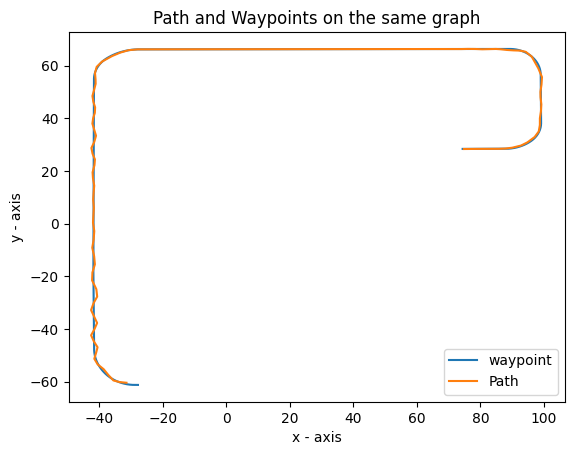

In [133]:
x_way = []
y_way = []
x_real = []
y_real = []
for x, y in waypoint_lst:
    x_way.append(x)
    y_way.append(y)

for x, y in implemented_route:
    x_real.append(x)
    y_real.append(y)

plt.plot(x_way, y_way, label = "waypoint")
plt.plot(x_real, y_real, label = 'Path')

# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Path and Waypoints on the same graph')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

In [134]:
''' Lets see if I can create a arbitrary route between two points but before that lets see how carla generates a path '''

sampling_resolution = 1
grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
route =  grp.trace_route(start_point, end_point)
print(route[10][0].transform.location)
i = 0
s, y=route[i]
print((route[i]))
for x,asadbhai in route:
    loc = x.transform.location
    x_,y_,z_ = (loc.x,loc.y,loc.z) 
    
    print(vel)
    # print(asadbhai)

Location(x=84.033546, y=28.417524, z=0.000000)
(<carla.libcarla.Waypoint object at 0x000001A677072990>, <RoadOption.LANEFOLLOW: 4>)
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.672918855484743
5.67